In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve
import matplotlib.pyplot as plt


In [2]:
df = pd.read_excel("C:/Users/gayat/Downloads/dataset_fraude_muestra_gratuita.xlsx")
df.head()


,transaccion_id,monto,hora_dia,dia_semana,ubicacion,tipo_dispositivo,edad_usuario,historial_usuario_dias,es_fraude
0,15021323,359.313347,8,6,CDMX,desktop,50,246.624541,0
1,315599,262.770165,18,5,CDMX,mobile,45,943.200168,0
2,3518902,154.319947,3,0,CDMX,mobile,32,719.060282,0
3,1576666,709.260923,6,5,CDMX,mobile,27,393.289463,0
4,14266574,284.943856,17,6,MTY,desktop,25,569.685105,0


In [3]:
df.shape

(4999, 9)

In [4]:
df.isnull().sum()

transaccion_id            0
monto                     0
hora_dia                  0
dia_semana                0
ubicacion                 0
tipo_dispositivo          0
edad_usuario              0
historial_usuario_dias    0
es_fraude                 0
dtype: int64

In [5]:
df = df.drop_duplicates()
df = df.select_dtypes(include=[np.number])
df.head()

,transaccion_id,monto,hora_dia,dia_semana,edad_usuario,historial_usuario_dias,es_fraude
0,15021323,359.313347,8,6,50,246.624541,0
1,315599,262.770165,18,5,45,943.200168,0
2,3518902,154.319947,3,0,32,719.060282,0
3,1576666,709.260923,6,5,27,393.289463,0
4,14266574,284.943856,17,6,25,569.685105,0


In [6]:
df.columns

Index(['transaccion_id', 'monto', 'hora_dia', 'dia_semana', 'edad_usuario',
       'historial_usuario_dias', 'es_fraude'],
      dtype='object')

In [8]:
df = df.rename(columns={
    "transaccion_id": "transaction_id",
    "monto": "transaction_amount",
    "hora_dia": "hour_of_day",
    "dia_semana": "day_of_week",
    "edad_usuario": "user_age",
    "historial_usuario_dias": "user_history_days",
    "es_fraude": "fraud"
})

df.head()


,transaction_id,transaction_amount,hour_of_day,day_of_week,user_age,user_history_days,fraud
0,15021323,359.313347,8,6,50,246.624541,0
1,315599,262.770165,18,5,45,943.200168,0
2,3518902,154.319947,3,0,32,719.060282,0
3,1576666,709.260923,6,5,27,393.289463,0
4,14266574,284.943856,17,6,25,569.685105,0


In [10]:
# Seperate Features and Target
X = df.drop("fraud", axis=1)
y = df["fraud"]


In [11]:
# Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)

In [14]:
iso = IsolationForest(
    n_estimators=200,
    contamination=0.02,
    random_state=42
)

iso.fit(X_train)


,n_estimators,200
,max_samples,'auto'
,contamination,0.02
,max_features,1.0
,bootstrap,False
,n_jobs,None
,random_state,42
,verbose,0
,warm_start,False


In [15]:
y_pred = iso.predict(X_test)
y_pred = np.where(y_pred == -1, 1, 0)


In [16]:
print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_pred))


              precision    recall  f1-score   support

           0       1.00      0.98      0.99       999
           1       0.00      0.00      0.00         1

    accuracy                           0.98      1000
   macro avg       0.50      0.49      0.50      1000
weighted avg       1.00      0.98      0.99      1000

ROC-AUC: 0.4914914914914915


In [17]:
scores = -iso.decision_function(X_test)


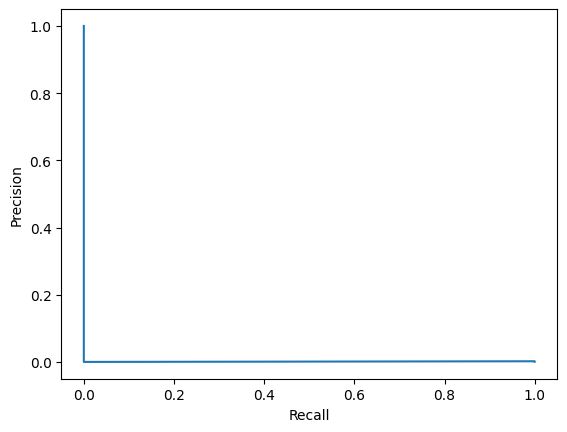

In [18]:
precision, recall, thresholds = precision_recall_curve(y_test, scores)

plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()


In [19]:
alerts = pd.DataFrame(X_test, columns=X.columns)
alerts["fraud_actual"] = y_test.values
alerts["risk_score"] = scores
alerts["alert"] = y_pred

alerts.sort_values("risk_score", ascending=False).head(10)


,transaction_id,transaction_amount,hour_of_day,day_of_week,user_age,user_history_days,fraud_actual,risk_score,alert
542,1.662908,-0.658366,1.082029,-1.503644,-0.873606,4.391690,0,0.034221,1
29,-0.880143,3.085406,1.682202,-1.503644,-0.873606,1.623705,0,0.032403,1
849,0.673429,3.989358,0.931985,-1.002162,2.565019,-0.788628,0,0.029055,1
451,1.584276,-1.033019,1.532159,-1.503644,-0.671334,3.295255,0,0.026768,1
724,0.088082,0.085625,0.931985,-1.503644,0.137755,4.868106,0,0.020649,1
960,-0.046306,5.618045,-0.118318,1.003767,-1.177014,1.779181,0,0.017238,1
396,1.446790,-0.955212,-0.268361,-1.002162,0.643435,4.426725,0,0.014358,1
693,1.428942,-0.652055,-1.618751,1.505249,-0.266790,3.853836,0,0.011782,1
145,1.631695,-0.082324,0.781942,-1.503644,-0.671334,3.635974,0,0.011394,1
813,-1.213870,-0.586777,1.532159,0.000803,1.553659,4.437664,0,0.010839,1


In [20]:
high_risk = alerts[alerts["risk_score"] > np.percentile(alerts["risk_score"], 95)]
high_risk.shape


(50, 9)

In [21]:
high_risk.to_csv("fraud_alerts.csv", index=False)


In [22]:
alerts = pd.read_csv("fraud_alerts.csv")
alerts.head()


,transaction_id,transaction_amount,hour_of_day,day_of_week,user_age,user_history_days,fraud_actual,risk_score,alert
0,-0.934051,0.061433,1.382115,1.003767,-1.682694,3.406966,0,0.006099,1
1,-0.880143,3.085406,1.682202,-1.503644,-0.873606,1.623705,0,0.032403,1
2,1.033558,1.270253,0.931985,-1.503644,-1.480422,1.187221,0,-0.022924,0
3,-1.215724,-0.603515,-1.468708,-1.503644,0.340027,3.505748,0,-0.002595,0
4,0.952646,3.539610,-1.768794,1.003767,1.553659,-0.479774,0,0.010060,1


In [23]:
p95 = alerts["risk_score"].quantile(0.95)
p90 = alerts["risk_score"].quantile(0.90)

alerts["alert_level"] = np.where(
    alerts["risk_score"] >= p95, "High",
    np.where(alerts["risk_score"] >= p90, "Medium", "Low")
)


In [24]:
total_txn = len(alerts)
total_alerts = alerts["alert"].sum()
high_risk = (alerts["alert_level"] == "High").sum()
fraud_rate = round((alerts["fraud_actual"].sum() / total_txn) * 100, 2)

total_txn, total_alerts, high_risk, fraud_rate


(50, np.int64(17), np.int64(3), np.float64(0.0))

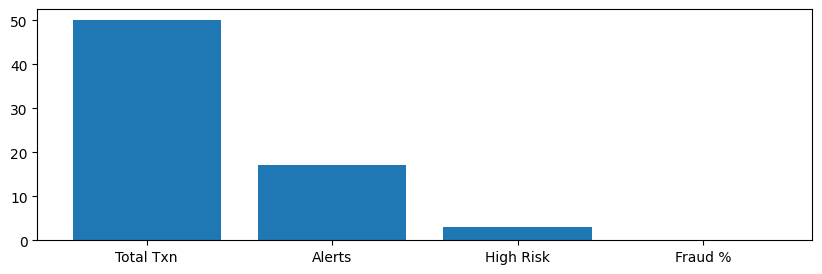

In [25]:
plt.figure(figsize=(10,3))
plt.bar(
    ["Total Txn", "Alerts", "High Risk", "Fraud %"],
    [total_txn, total_alerts, high_risk, fraud_rate]
)
plt.show()


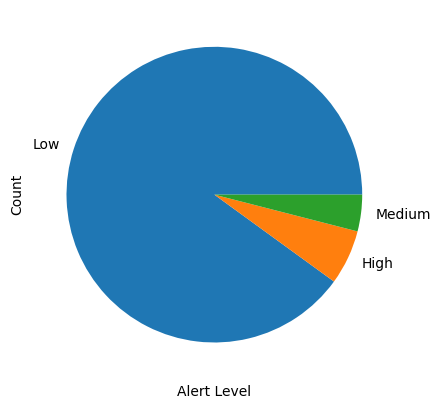

In [27]:
alerts["alert_level"].value_counts().plot(kind="pie")
plt.xlabel("Alert Level")
plt.ylabel("Count")
plt.show()


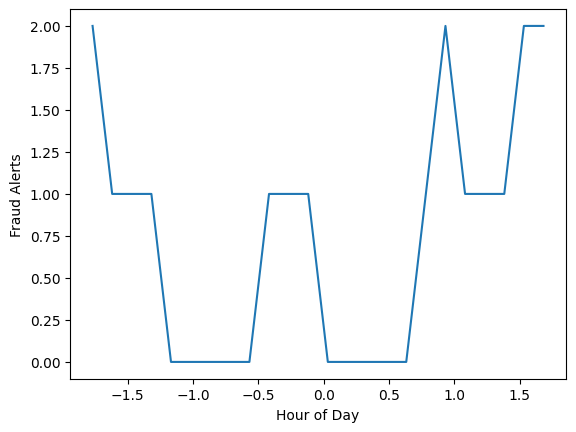

In [28]:
alerts.groupby("hour_of_day")["alert"].sum().plot()
plt.xlabel("Hour of Day")
plt.ylabel("Fraud Alerts")
plt.show()


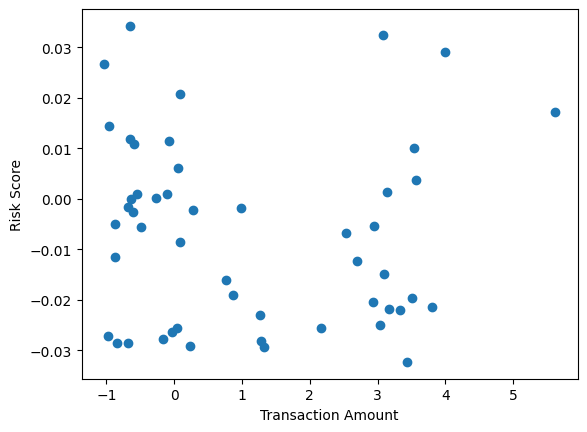

In [29]:
plt.scatter(alerts["transaction_amount"], alerts["risk_score"])
plt.xlabel("Transaction Amount")
plt.ylabel("Risk Score")
plt.show()


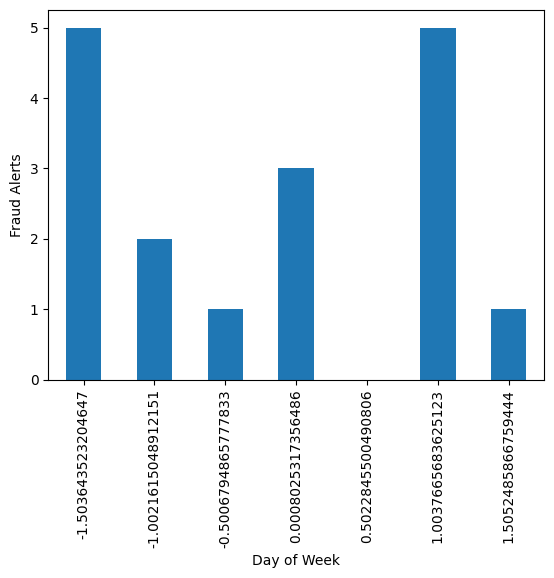

In [30]:
alerts.groupby("day_of_week")["alert"].sum().plot(kind="bar")
plt.xlabel("Day of Week")
plt.ylabel("Fraud Alerts")
plt.show()


In [31]:
alerts[alerts["alert_level"] == "High"]\
    .sort_values("risk_score", ascending=False)\
    .head(10)


,transaction_id,transaction_amount,hour_of_day,day_of_week,user_age,user_history_days,fraud_actual,risk_score,alert,alert_level
29,1.662908,-0.658366,1.082029,-1.503644,-0.873606,4.391690,0,0.034221,1,High
1,-0.880143,3.085406,1.682202,-1.503644,-0.873606,1.623705,0,0.032403,1,High
45,0.673429,3.989358,0.931985,-1.002162,2.565019,-0.788628,0,0.029055,1,High


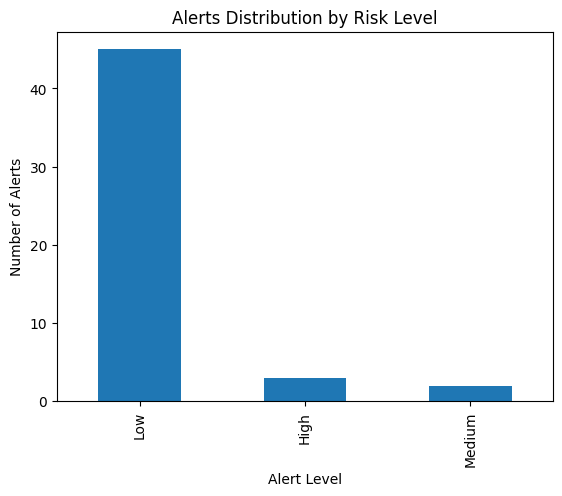

In [33]:
alerts["alert_level"].value_counts().plot(kind="bar")
plt.xlabel("Alert Level")
plt.ylabel("Number of Alerts")
plt.title("Alerts Distribution by Risk Level")
plt.show()


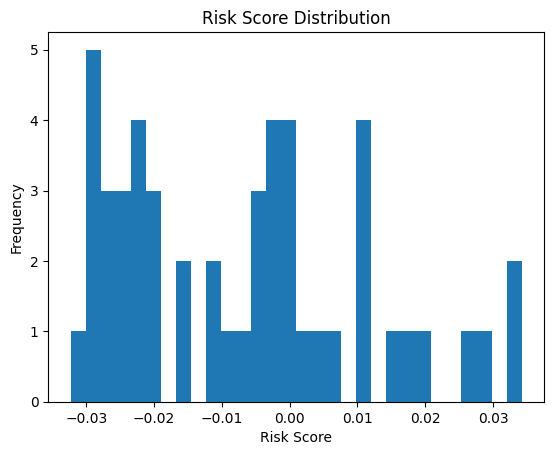

In [34]:
plt.hist(alerts["risk_score"], bins=30)
plt.xlabel("Risk Score")
plt.ylabel("Frequency")
plt.title("Risk Score Distribution")
plt.show()


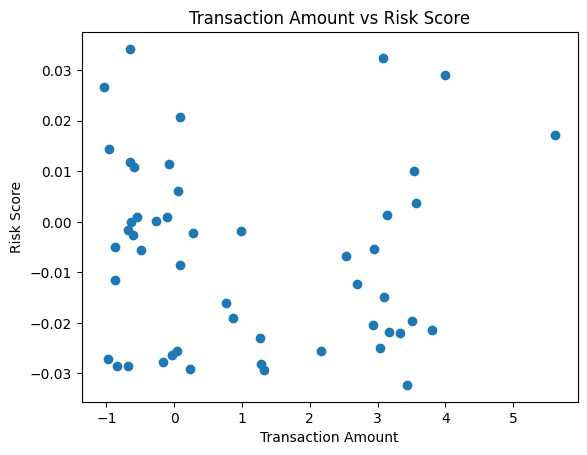

In [35]:
plt.scatter(alerts["transaction_amount"], alerts["risk_score"])
plt.xlabel("Transaction Amount")
plt.ylabel("Risk Score")
plt.title("Transaction Amount vs Risk Score")
plt.show()
